In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import nltk
from nltk.corpus import stopwords
from termcolor import colored
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, auc
from termcolor import colored
from nltk.stem.wordnet import WordNetLemmatizer
from string import punctuation
from nltk.tokenize import word_tokenize

In [82]:
lemma = WordNetLemmatizer()
STOPWORDS=set(stopwords.words('english')+list(punctuation))
STOPWORDS.remove("not")

# LOADING LABELLED DATA

In [8]:
sentimentData=pd.read_csv('data/proData/sentimentData.csv')

In [9]:
sentimentData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6848 entries, 0 to 6847
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TweetsID         6848 non-null   int64 
 1   TweetsText       6848 non-null   object
 2   User_Location    6848 non-null   object
 3   Date             6848 non-null   object
 4   Baseline_Terms   6848 non-null   object
 5   Prediction       6848 non-null   int64 
 6   Positive         6848 non-null   int64 
 7   Negative         6848 non-null   int64 
 8   Sentiment_score  6848 non-null   object
dtypes: int64(4), object(5)
memory usage: 481.6+ KB


In [50]:
sentimentData.head(2)

,TweetsID,TweetsText,User_Location,Date,Baseline_Terms,Prediction,Positive,Negative,Sentiment_score
0,1216910000000000000,were doing everything we can to get our studen...,LOCATION,24/10/2020 03:29,"['get', 'need', 'get']",1,2,-1,Positive
1,191554292,dsnap approved for 5 louisiana parishes hit by...,"Baton Rouge, LA",23/10/2020 23:01,['hit'],1,1,-1,Neutral


In [51]:
processing_Data=sentimentData.copy() #caching to another Dataframe

In [ ]:
# Dropping Columns not required for training the classifier

In [52]:
processing_Data.drop(['TweetsID','User_Location','Date','Baseline_Terms','Prediction','Positive','Negative'], axis = 1, inplace = True)

In [ ]:
# Performing labelling encoding

In [53]:
processing_Data.loc[processing_Data['Sentiment_score']=='Positive','Sentiment_score']=1

In [54]:
processing_Data.loc[processing_Data['Sentiment_score']=='Neutral','Sentiment_score']=0

In [55]:
processing_Data.loc[processing_Data['Sentiment_score']=='Negative','Sentiment_score']=-1

In [56]:
processing_Data.head()

,TweetsText,Sentiment_score
0,were doing everything we can to get our studen...,1
1,dsnap approved for 5 louisiana parishes hit by...,0
2,hurricanelaura 2020 devastation destruction f...,-1
3,this is for people in the area who were affect...,0
4,after suffering catastrophic loss to infrastru...,-1


In [57]:
# Comparing the out of the encoding to confirm it talllies with Cell 26(Distinct tweets)
print("Total distinct tweets in the dataset: {}".format(processing_Data.shape[0]))
Tweet_count = processing_Data['Sentiment_score'].value_counts()
Tweet_count

Total distinct tweets in the dataset: 6848


 0    2902
-1    2011
 1    1935
Name: Sentiment_score, dtype: int64

# Splitting to Train and Test Data

In [85]:
dF_features=processing_Data['TweetsText']
dF_target=processing_Data['Sentiment_score']

In [86]:
X_train, x_test, y_train, y_test = train_test_split(dF_features, dF_target, test_size=0.2, random_state=11)

In [87]:
y_train=y_train.astype('int')
expected=y_test=y_test.astype('int')

In [88]:
print()
train_dataset = pd.DataFrame({'TweetsText': X_train,'Category': y_train})
print(colored("Percentage of training dataset is : %.1f%%" % (len(train_dataset)/len(processing_Data)*100),"green"))
print(train_dataset['Category'].value_counts())
print()


test_dataset = pd.DataFrame({'TweetsText': x_test,'Category': y_test})
print(colored("Percentage of testing dataset is: %.1f%%" % (len(test_dataset)/len(processing_Data)*100),"green"))
print(test_dataset['Category'].value_counts())

train_tweet_label =train_dataset['Category'].astype('int')
test_tweet_label = test_dataset['Category'].astype('int')


Percentage of training dataset is : 80.0%
 0    2322
-1    1610
 1    1546
Name: Category, dtype: int64

Percentage of testing dataset is: 20.0%
 0    580
-1    401
 1    389
Name: Category, dtype: int64


# Performing Features Extraction

In [83]:
features_Extractor=TfidfVectorizer(analyzer=lemmatize_func,min_df=1,stop_words=STOPWORDS)

In [89]:
train_tweet_vector =features_Extractor.fit_transform(train_dataset['TweetsText'])
test_tweet_vector = features_Extractor.transform(test_dataset['TweetsText'])

In [90]:
MNB_estimator = classifier(MultinomialNB(),train_tweet_vector,train_tweet_label,test_tweet_vector) #MNB_estimator

In [91]:
decisionTree_estimator=classifier(DecisionTreeClassifier(),train_tweet_vector,train_tweet_label,test_tweet_vector) #decisionTree_estimator

# Model Evaluation:

# Accuracy Scores

In [92]:
accuracy()

       MultinomialNB: accuracy score=55.26%; 
        DecisionTree: accuracy score=61.02%; 


# Classification_Reports

In [93]:
classification_Reports()

       MultinomialNB: classification_report
              precision    recall  f1-score   support

          -1       0.77      0.24      0.36       401
           0       0.49      0.93      0.64       580
           1       0.83      0.31      0.46       389

    accuracy                           0.55      1370
   macro avg       0.70      0.49      0.49      1370
weighted avg       0.67      0.55      0.51      1370

        DecisionTree: classification_report
              precision    recall  f1-score   support

          -1       0.59      0.51      0.55       401
           0       0.58      0.64      0.61       580
           1       0.60      0.59      0.60       389

    accuracy                           0.59      1370
   macro avg       0.59      0.58      0.58      1370
weighted avg       0.59      0.59      0.59      1370



# Cross Validation using 10 folds

In [94]:
validation_Report()  #Cross Validation using 10 folds

       MultinomialNB: mean accuracy=53.56%; standard deviation=1.52%
        DecisionTree: mean accuracy=58.82%; standard deviation=1.26%


# Confusion_Matrix

       MultinomialNB: confusion matrix score
[[ 95 299   7]
 [ 22 540  18]
 [  6 261 122]]

        DecisionTree: confusion matrix score
[[227 132  42]
 [ 98 378 104]
 [ 44 114 231]]



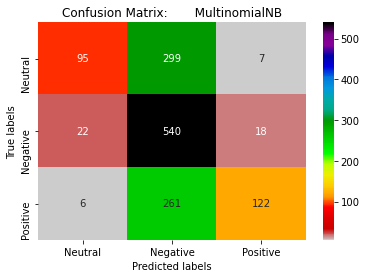

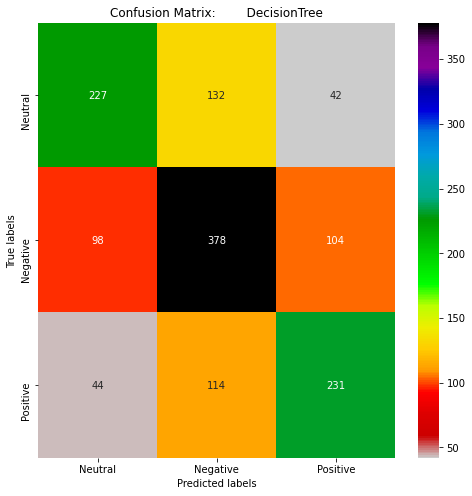

<Figure size 576x576 with 0 Axes>

In [101]:
confusion_Matrix()

# AUC ROC

In [99]:
plot_roc_curve()

# Pre-Processing functions

In [67]:
# 1.User defined functuions to replace Emoji`s found in tweets

In [68]:
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet

In [ ]:
# 2.User defined functuions to remove noise from tweets

In [69]:
def process_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', 'RT', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()
    return ' '.join(words)

In [ ]:
# 3.User defined functuions to tokennize tweets

In [70]:
def lemmatize_func(tweets):
    tweets_Text=tweets.lower()
    words = word_tokenize(tweets_Text)
    valid_Words=[]
    for word in words :
        if word in STOPWORDS:continue
        valid_Words.append(word)
    return [lemma.lemmatize(word) for word in valid_Words]

In [71]:
# 4.User defined Dynamic Estimators/Classifiers

In [72]:
def classifier(estimator,training_features,training_labels,test_features):
    estimator_object = estimator
    estimator_object.fit(training_features, training_labels)
    predicted= estimator_object.predict(test_features)
    return predicted

In [73]:
# 5.User defined enumerator to group classifier

In [74]:
estimators = {
    'MultinomialNB': MultinomialNB(),
     'DecisionTree': DecisionTreeClassifier()
}

In [ ]:
# 6.User defined function to compute 10-fold cross-validation

In [75]:
def validation_Report():
    for estimator_name, estimator_object in estimators.items():
        kfold = KFold(n_splits=10, random_state=7, shuffle=True)
        scores = cross_val_score(estimator=estimator_object,
        X=train_tweet_vector, y=train_tweet_label, cv=kfold)
        print(colored(f'{estimator_name:>20}: ' +
        f'mean accuracy={scores.mean():.2%}; ' +
        f'standard deviation={scores.std():.2%}',"green"))

In [ ]:
# 7. Function to compute Accuracy

In [76]:
def accuracy():
    for estimator_name, estimator_object in estimators.items():
        model=estimator_object
        model.fit(train_tweet_vector,train_tweet_label)
        scores =model.score(test_tweet_vector, test_tweet_label)
        print(f'{estimator_name:>20}: ' +
        f'accuracy score={scores:.2%}; ')

In [ ]:
# 8. Function to plot Confusion Matrix

In [100]:
def confusion_Matrix():
    for estimator_name, estimator_object in estimators.items():
        model=estimator_object
        confusion = confusion_matrix(test_tweet_label, classifier(model,train_tweet_vector,train_tweet_label,test_tweet_vector))
        print(colored(f'{estimator_name:>20}: ' +
        f'confusion matrix score',"green"))
        print(confusion)
        confusion_df = pd.DataFrame(confusion, index=range(3),columns=range(3))
        print()
        ax= plt.subplot()
        sns.heatmap(confusion_df, annot=True,ax=ax,cmap='nipy_spectral_r',fmt ='d') 
        plt.figure(figsize=(8, 8))
        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix:'f'{estimator_name:>20}'); 
        ax.xaxis.set_ticklabels(['Neutral', 'Negative','Positive']); ax.yaxis.set_ticklabels(['Neutral', 'Negative','Positive'])

In [ ]:
# 9. Function to plot AUC ROC

In [79]:
def plot_roc_curve():
    for estimator_name, estimator_object in estimators.items():
        model=estimator_object
        model.fit(train_tweet_vector,train_tweet_label)
        preds = model.predict_proba(test_tweet_vector)[:,1]
        fpr, tpr, threshold = roc_curve(expected, preds)
        roc_auc = auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic:'f'{estimator_name:>20}')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [ ]:
# 10. Function to compute classification report

In [80]:
def classification_Reports():
    for estimator_name, estimator_object in estimators.items():
        model=estimator_object
        class_reports = (classification_report(test_tweet_label, classifier(model,train_tweet_vector,train_tweet_label,test_tweet_vector)))
        #scores =model.score(test_tweet_vector, test_tweet_label)
        print(colored(f'{estimator_name:>20}: ' +
        f'classification_report',"green"))
        print(class_reports)